In [1]:
# Import all required packages
import os

# List of required packages
"""
This method is used to automatically detect whether the libraries needed belong to the Docker image 
and automatically install the non-existent libraries. It is obtained with the help of ChatGPT.
"""
required_packages = [
    "geopandas",
    "matplotlib",
    "numpy",
    "pandas",
    "matplotlib-scalebar",
    "scipy",
    "shapely"
]

def install_package(package):
    """
    Check if a package is installed. If not, install it using os.system.
    """
    try:
        __import__(package.split('-')[0])  # Dynamically import the package (handle hyphenated names)
        #print(f"{package} is already installed.")
    except ImportError:
        #print(f"{package} is not installed. Installing now...")
        os.system(f"pip install {package}")
        #print(f"{package} installation completed.")

# Install all required packages
for package in required_packages:
    install_package(package)

# Import packages after ensuring installation
# print("Importing all required libraries...")

import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gaussian_kde
from shapely.geometry import Polygon
from shapely.ops import unary_union

#print("All libraries have been successfully imported and are ready to use!")


# Define the scale bar function
def add_scale_bar(
    ax,
    scale_bar_start=0.05,
    scale_bar_length=0.2,
    scale_bar_y=0.02,
    scale_bar_thickness=600,
    scale_unit="km",
    labels_interval=5,
    zorder=10,
):
    """
    Add a custom scale bar to a matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to which the scale bar will be added.
        scale_bar_start (float): Starting position of the scale bar on the x-axis (fraction of total width).
        scale_bar_length (float): Total length of the scale bar (fraction of total width).
        scale_bar_y (float): Position of the scale bar on the y-axis (fraction of total height).
        scale_bar_thickness (int): Thickness of the scale bar in data coordinates (e.g., meters).
        scale_unit (str): Unit of the scale (e.g., 'km').
        labels_interval (int): Interval for scale labels in the given unit.
        zorder (int): Drawing order of the scale bar.
    """

    x_start, x_end = ax.get_xlim()
    y_start, y_end = ax.get_ylim()

    bar_x_start = x_start + scale_bar_start * (x_end - x_start)
    bar_x_end = bar_x_start + scale_bar_length * (x_end - x_start)
    bar_y = y_start + scale_bar_y * (y_end - y_start)

    num_sections = int(
        1 / (scale_bar_length / labels_interval)
    )  # Number of alternating sections
    bar_width = (bar_x_end - bar_x_start) / num_sections
    colors = ["black", "white"] * (num_sections // 2 + 1)

    for i in range(num_sections):
        rect = Rectangle(
            (bar_x_start + i * bar_width, bar_y),
            bar_width,
            scale_bar_thickness,
            color=colors[i],
            transform=ax.transData,
            clip_on=False,
            zorder=zorder,
        )
        ax.add_patch(rect)

    for i in range(num_sections + 1):
        ax.text(
            bar_x_start + i * bar_width,
            bar_y + scale_bar_thickness * 1.5,
            f"{i * labels_interval}",
            fontsize=10,
            color="black",
            ha="center",
            transform=ax.transData,
            zorder=zorder,
        )

    scale_bar_border = Rectangle(
        (bar_x_start, bar_y),
        bar_x_end - bar_x_start,
        scale_bar_thickness,
        linewidth=0.7,
        edgecolor="black",
        facecolor="none",
        transform=ax.transData,
        clip_on=False,
        zorder=zorder,
    )

    ax.add_patch(scale_bar_border)

    ax.text(
        bar_x_start + num_sections * bar_width + 0.3 * bar_width,
        bar_y + scale_bar_thickness * 1.5,
        scale_unit,
        fontsize=8,
        color="black",
        ha="left",
        transform=ax.transData,
        zorder=zorder,
    )

In [2]:
# Read in cleaned Inside Airbnb data
# (Please see the code for cleaning data:https://github.com/ukilay/PANA-FSDS-GROUP/blob/main/Cleaned%20Data/Data%20Cleaning%20Dec24.ipynb)
csv_urls = {
    2016: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2016_data.csv",
    2019: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2019_data.csv",
    2020: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2020_data.csv",
    2021: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2021_data.csv",
    2022: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2022_data.csv",
    2023: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2023_data.csv",
    2024: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2024_data.csv",
}

data_2016 = pd.read_csv(csv_urls[2016])
data_2019 = pd.read_csv(csv_urls[2019])
data_2020 = pd.read_csv(csv_urls[2020])
data_2021 = pd.read_csv(csv_urls[2021])
data_2022 = pd.read_csv(csv_urls[2022])
data_2023 = pd.read_csv(csv_urls[2023])
data_2024 = pd.read_csv(csv_urls[2024])


# Read in shapefile of London's Borough
shapefile_url = "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/data/London_Borough/London_Borough_Excluding_MHW.shp"

boroughs = gpd.read_file(shapefile_url)
boroughs = boroughs.to_crs(epsg=27700)  # Ensure its projection to EPSG:27700

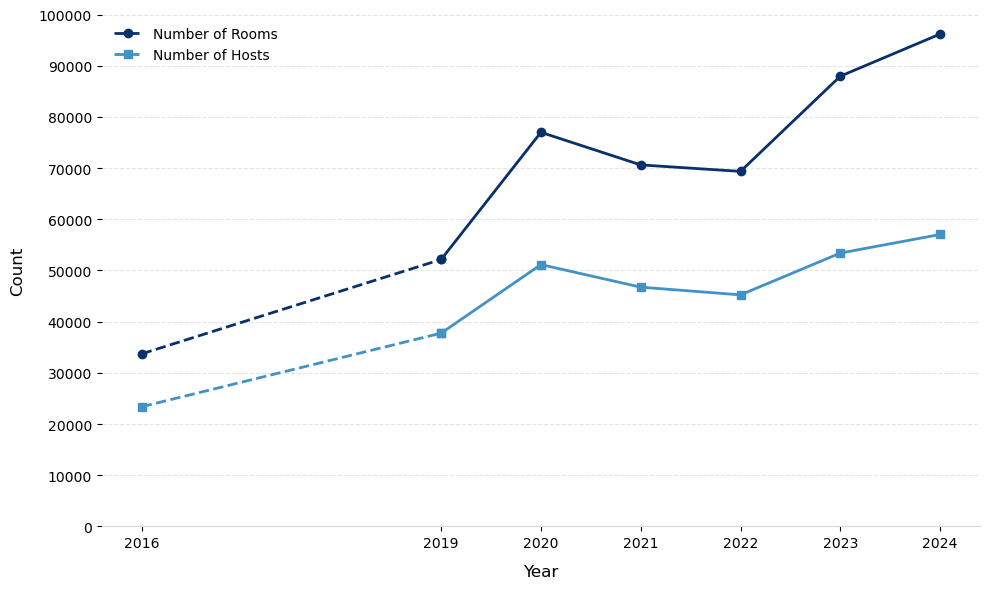

In [3]:
# Figure 1: Airbnb Trends, Number of Rooms and Hosts (2016, 2019-2024)
data_2016["year"] = 2016
data_2019["year"] = 2019
data_2020["year"] = 2020
data_2021["year"] = 2021
data_2022["year"] = 2022
data_2023["year"] = 2023
data_2024["year"] = 2024

# Combine all data
all_data = pd.concat(
    [data_2016, data_2019, data_2020, data_2021, data_2022, data_2023, data_2024]
)

# Calculate the total number of listings and unique hosts for each year
room_count = all_data.groupby("year")["id"].count()
host_count = all_data.groupby("year")["host_id"].nunique()

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot rooms and hosts with segmented line styles
plt.plot(
    room_count.index[:2],
    room_count.values[:2],
    marker="o",
    label="Number of Rooms",
    color="#08306B",
    linewidth=2,
    linestyle="--",
)  # Dashed for 2016-2019
plt.plot(
    room_count.index[1:],
    room_count.values[1:],
    marker="o",
    color="#08306B",
    linewidth=2,
)  # Solid for 2019-2024

plt.plot(
    host_count.index[:2],
    host_count.values[:2],
    marker="s",
    label="Number of Hosts",
    color="#4292C6",
    linewidth=2,
    linestyle="--",
)  # Dashed for 2016-2019
plt.plot(
    host_count.index[1:],
    host_count.values[1:],
    marker="s",
    color="#4292C6",
    linewidth=2,
)  # Solid for 2019-2024

# Add title, grid, and labels
plt.xlabel("Year", fontsize=12, labelpad=10)
plt.ylabel("Count", fontsize=12, labelpad=10)

# Set Y-axis limit to 100,000
plt.ylim(0, 100000)

# Set Y-axis ticks with 10000 intervals
plt.yticks(range(0, 100001, 10000))

# Customize the axes and gridlines
plt.grid(
    axis="y", color="#D9D9D9", linestyle="--", linewidth=0.8, alpha=0.7
)  # Show horizontal gridlines only
plt.gca().spines["top"].set_visible(False)  # Remove the top border
plt.gca().spines["right"].set_visible(False)  # Remove the right border
plt.gca().spines["left"].set_visible(False)  # Remove the left border
plt.gca().spines["bottom"].set_color("#D9D9D9")  # Set bottom border to light gray

# Adjust tick styles
plt.xticks(room_count.index, fontsize=10)
plt.yticks(fontsize=10)

# Set legend
plt.legend(
    fontsize=10, loc="upper left", frameon=False
)  # Single legend for simplified understanding

# Display the plot
plt.tight_layout()
plt.show()

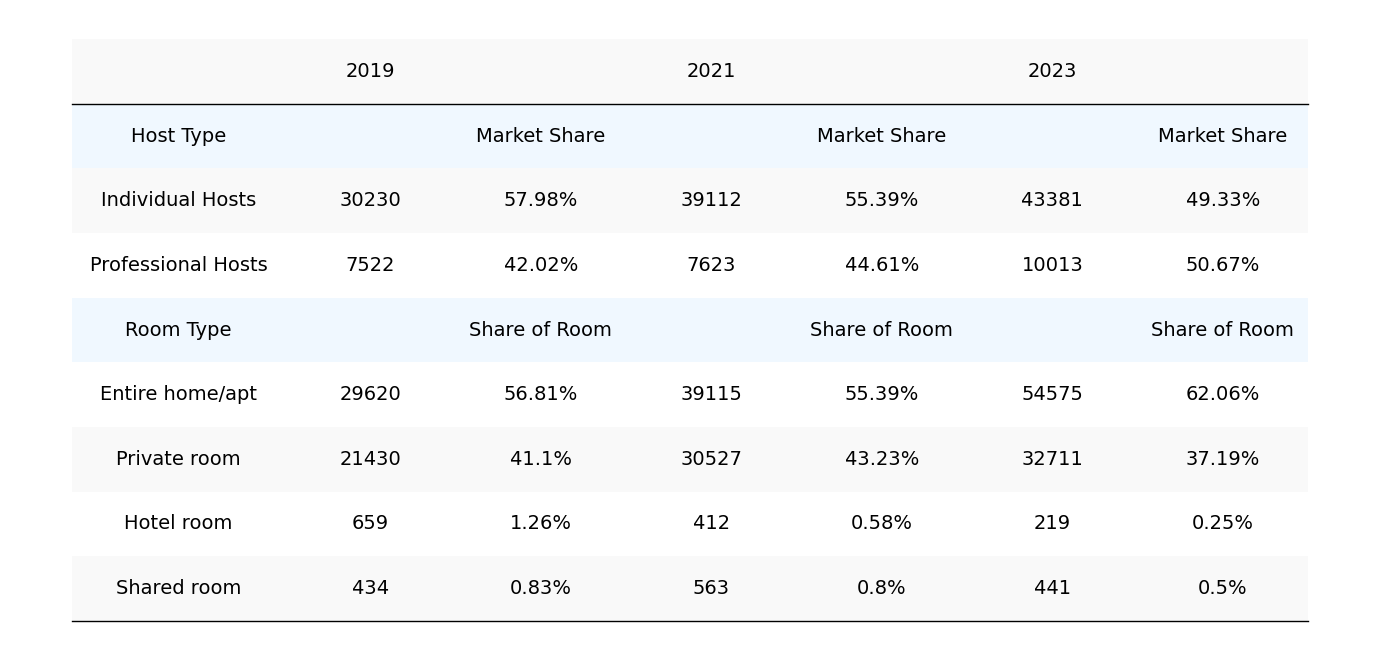

In [4]:
# Table 1: Host and Room Type Analysis (2019, 2021, 2023)

# Function to calculate market share and unique hosts for two host types
def calculate_metrics(data):
    total_listings = data.shape[0]  # Total number of listings
    host_type_1 = data[data['calculated_host_listings_count'] == 1]
    host_type_gt_1 = data[data['calculated_host_listings_count'] > 1]
    
    metrics = {
        'Individual Hosts - Market Share (%)': round((host_type_1.shape[0] / total_listings) * 100, 2),
        'Professional Hosts - Market Share (%)': round((host_type_gt_1.shape[0] / total_listings) * 100, 2),
        'Individual Hosts - Unique Count': host_type_1['host_id'].nunique(),
        'Professional Hosts - Unique Count': host_type_gt_1['host_id'].nunique()
    }
    return metrics

# Function to calculate room type market share
def calculate_room_market_share(data):
    total_listings = data.shape[0]  # Total number of listings
    room_counts = data['room_type'].value_counts()  # Total listings by room type
    market_share = (room_counts / total_listings) * 100  # Market share by room type
    return room_counts, market_share

# Step 1: Host Metrics Initialization
metrics_results = {
    'year': [],
    'Individual Hosts - Market Share (%)': [],
    'Professional Hosts - Market Share (%)': [],
    'Individual Hosts - Unique Count': [],
    'Professional Hosts - Unique Count': []
}

# Step 2: Room Type Market Share Initialization
room_counts_results = {}
room_market_results = {}

# Step 3: Calculate metrics by year
for year, data in zip([2019, 2021, 2023], [data_2019, data_2021, data_2023]):
    # Host metrics
    metrics = calculate_metrics(data)
    metrics_results['year'].append(year)
    metrics_results['Individual Hosts - Market Share (%)'].append(metrics['Individual Hosts - Market Share (%)'])
    metrics_results['Professional Hosts - Market Share (%)'].append(metrics['Professional Hosts - Market Share (%)'])
    metrics_results['Individual Hosts - Unique Count'].append(metrics['Individual Hosts - Unique Count'])
    metrics_results['Professional Hosts - Unique Count'].append(metrics['Professional Hosts - Unique Count'])
    
    # Room type market share
    room_counts, room_market = calculate_room_market_share(data)
    room_counts_results[year] = room_counts
    room_market_results[year] = room_market

# Step 4: Convert host metrics to DataFrame
metrics_df = pd.DataFrame(metrics_results)

# Step 5: Convert room type results to DataFrame
room_type_df = pd.DataFrame({
    'Type': room_counts_results[2019].index,
    '2019': room_counts_results[2019].values,
    '2019 Market Share (%)': room_market_results[2019].round(2).values,
    '2021': room_counts_results[2021].reindex(room_counts_results[2019].index, fill_value=0).values,
    '2021 Market Share (%)': room_market_results[2021].reindex(room_counts_results[2019].index, fill_value=0).round(2).values,
    '2023': room_counts_results[2023].reindex(room_counts_results[2019].index, fill_value=0).values,
    '2023 Market Share (%)': room_market_results[2023].reindex(room_counts_results[2019].index, fill_value=0).round(2).values
})

# Step 6: Build Final Table
host_data = [
    ["Individual Hosts", metrics_df.loc[0, 'Individual Hosts - Unique Count'],
     f"{metrics_df.loc[0, 'Individual Hosts - Market Share (%)']}%", 
     metrics_df.loc[1, 'Individual Hosts - Unique Count'],
     f"{metrics_df.loc[1, 'Individual Hosts - Market Share (%)']}%", 
     metrics_df.loc[2, 'Individual Hosts - Unique Count'],
     f"{metrics_df.loc[2, 'Individual Hosts - Market Share (%)']}%"],
    ["Professional Hosts", metrics_df.loc[0, 'Professional Hosts - Unique Count'],
     f"{metrics_df.loc[0, 'Professional Hosts - Market Share (%)']}%", 
     metrics_df.loc[1, 'Professional Hosts - Unique Count'],
     f"{metrics_df.loc[1, 'Professional Hosts - Market Share (%)']}%", 
     metrics_df.loc[2, 'Professional Hosts - Unique Count'],
     f"{metrics_df.loc[2, 'Professional Hosts - Market Share (%)']}%"]
]

room_data = [
    [room_type_df.loc[i, 'Type'], room_type_df.loc[i, '2019'],
     f"{room_type_df.loc[i, '2019 Market Share (%)']}%",
     room_type_df.loc[i, '2021'],
     f"{room_type_df.loc[i, '2021 Market Share (%)']}%",
     room_type_df.loc[i, '2023'],
     f"{room_type_df.loc[i, '2023 Market Share (%)']}%"]
    for i in range(len(room_type_df))
]

# Step 7: Combine Table Structure
table_data = [
    ["", "2019", "", "2021", "", "2023", ""],
    ["Host Type", "", "Market Share", "", "Market Share", "", "Market Share"]
] + host_data + [
    ["Room Type", "", "Share of Room", "", "Share of Room", "", "Share of Room"]
] + room_data

# Step 8: Visualization
fig, ax = plt.subplots(figsize=(17, 8))
ax.axis("off")

cell_height = 1 / len(table_data)
col_widths = [0.15, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12]
cumulative_widths = [sum(col_widths[:i]) for i in range(len(col_widths) + 1)]

for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        x = cumulative_widths[j]
        y = 1 - (i + 1) * cell_height
        color = "#f0f8ff" if i in [1, 4] else "#f9f9f9" if i % 2 == 0 else "white"
        ax.add_patch(Rectangle((x, y), col_widths[j], cell_height, facecolor=color, edgecolor="none"))
        ax.text(x + col_widths[j] / 2, y + cell_height / 2, str(cell), ha="center", va="center", fontsize=14)

ax.plot([0, cumulative_widths[-1]], [1 - cell_height, 1 - cell_height], color="black", linewidth=1)
ax.plot([0, cumulative_widths[-1]], [0, 0], color="black", linewidth=1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()


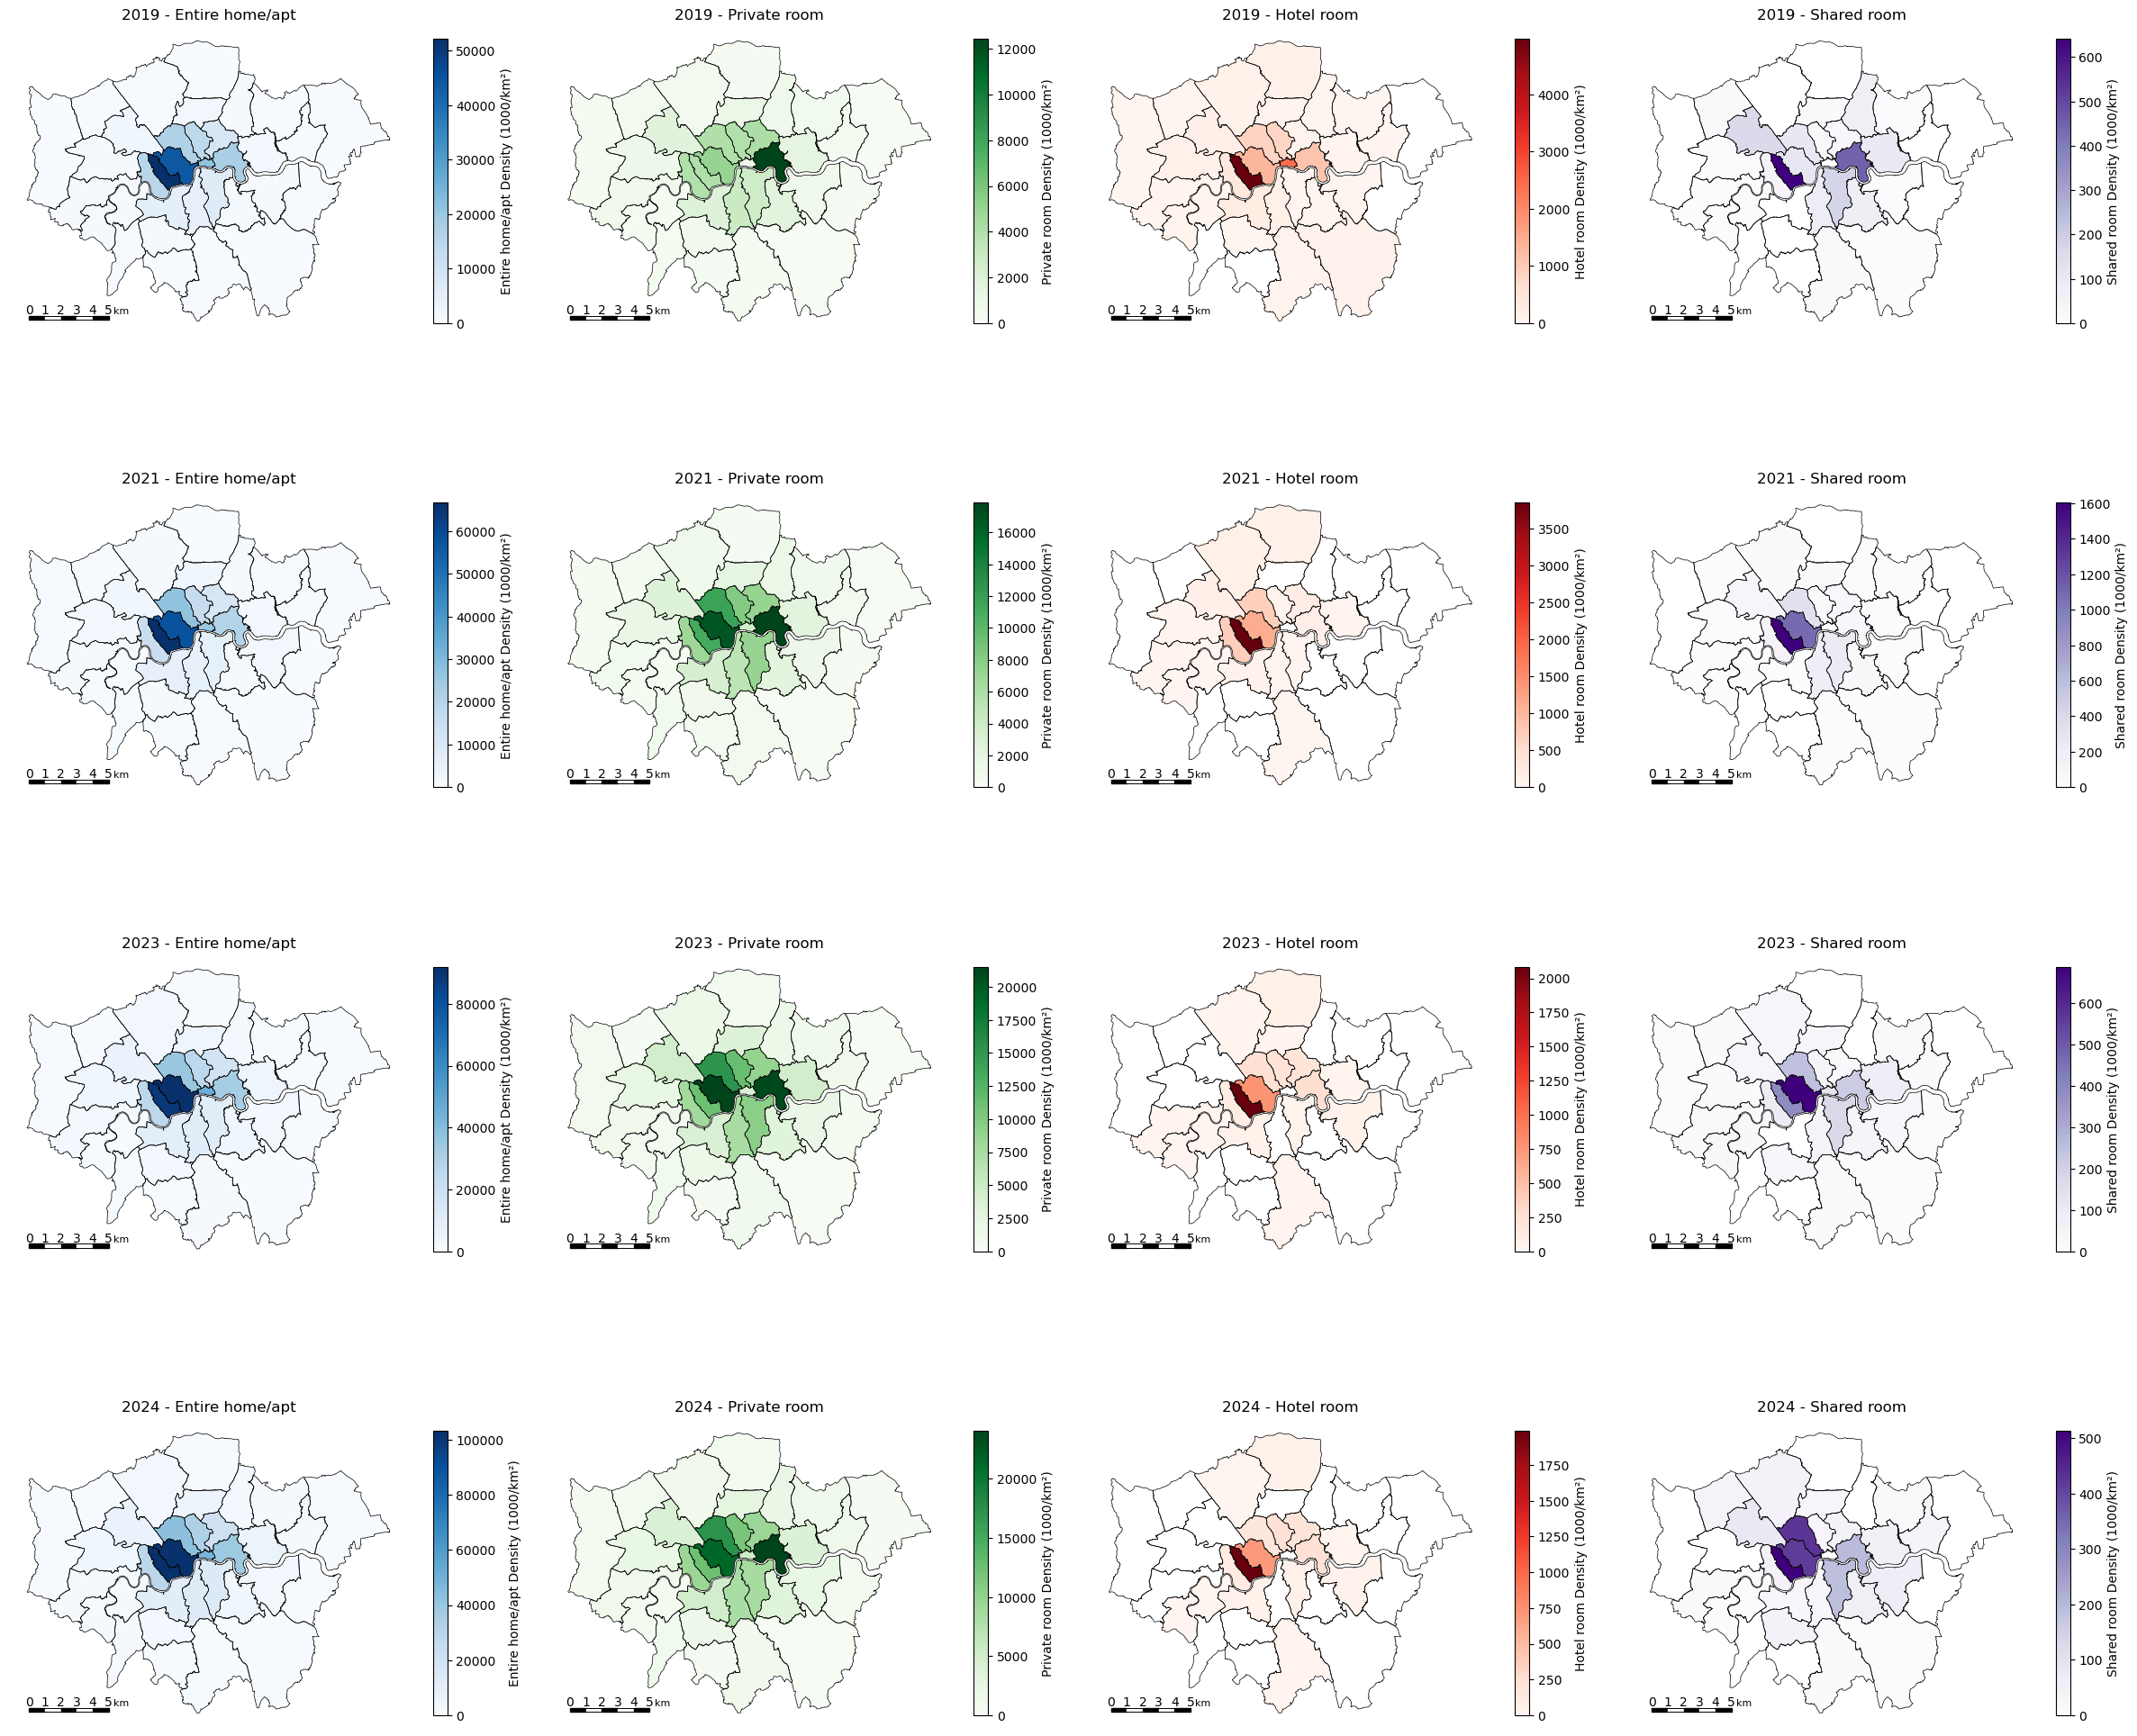

In [5]:
# Figure 2: Professional Host Density by Room Type in London (2019, 2021, 2023)
boroughs["area_km2"] = (
    boroughs["geometry"].to_crs(epsg=3395).area / 1e6
)  # Calculate the area of each borough

# data processing
columns_needed = [
    "year",
    "host_id",
    "calculated_host_listings_count",
    "neighbourhood_cleansed",
    "room_type",
]
host_data = all_data[columns_needed].dropna()

# Add Host type
host_data["host_type"] = host_data["calculated_host_listings_count"].apply(
    lambda x: "Non-professional" if x <= 2 else "Professional"
)

# Calculate Professional Host density of each borough
host_counts = (
    host_data.groupby(["year", "neighbourhood_cleansed", "room_type", "host_type"])
    .size()
    .reset_index(name="count")
)
host_counts = host_counts.merge(
    boroughs[["NAME", "area_km2"]],
    left_on="neighbourhood_cleansed",
    right_on="NAME",
    how="left",
)
host_counts["density"] = (host_counts["count"] / host_counts["area_km2"]) * 1000

# Convert to GeoDataFrame
boroughs = boroughs.rename(columns={"NAME": "borough"})
data_geo = pd.merge(
    boroughs,
    host_counts,
    how="left",
    left_on="borough",
    right_on="neighbourhood_cleansed",
)

# Obtain unique room types and years
room_types = host_data["room_type"].unique()
years = host_data["year"].unique()


# Plotting
def plot_combined_professional_density(
    data_geo, years, room_types, title, output_file, boroughs
):
    fig, axes = plt.subplots(
        len(years), len(room_types), figsize=(len(room_types) * 6, len(years) * 6)
    )
    colormaps = ["Blues", "Greens", "Reds", "Purples"]

    for row, year in enumerate(years):
        year_data = data_geo[data_geo["year"] == year]
        professional_data = year_data[year_data["host_type"] == "Professional"]

        for col, room_type in enumerate(room_types):
            cmap = colormaps[col % len(colormaps)]

            # Plot Professional Hosts
            ax = axes[row, col]
            subset = professional_data[professional_data["room_type"] == room_type]
            boroughs.boundary.plot(ax=ax, color="black", linewidth=0.5)
            subset.plot(
                column="density",
                cmap=cmap,
                legend=True,
                legend_kwds={"label": f"{room_type} Density (1000/km²)", "shrink": 0.5},
                ax=ax,
                vmin=0,
                vmax=subset["density"].max(),
                missing_kwds={"color": "lightgrey", "label": "No data"},
            )
            ax.set_title(f"{year} - {room_type}", fontsize=12)
            ax.axis("off")
            add_scale_bar(
                ax,
                scale_bar_start=0.05,
                scale_bar_length=0.2,
                scale_bar_y=0.05,
                scale_bar_thickness=600,
                scale_unit="km",
                labels_interval=1,
            )

    # Set overall title
    #plt.suptitle(title, fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(output_file, dpi=300)
    plt.show()


# Draw the density distribution map of professional hosts.
plot_combined_professional_density(
    data_geo,
    years,
    room_types,
    "Professional Host Density by Room Type in London (2016-2024)",
    "combined_professional_host_density.png",
    boroughs,
)

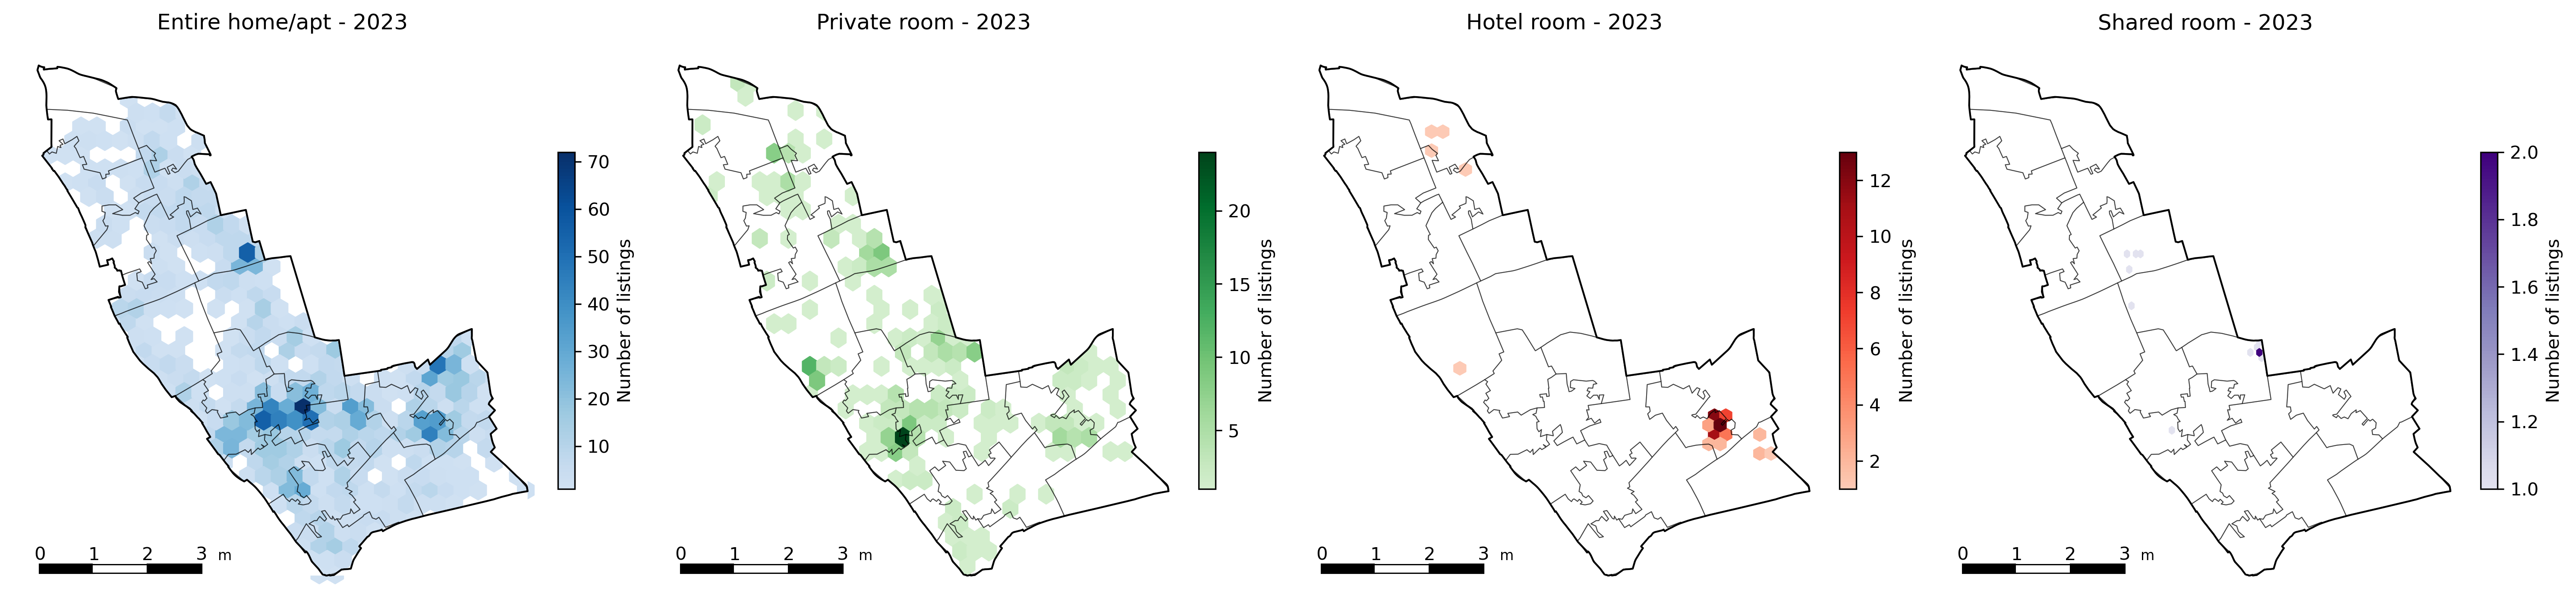

In [6]:
# Figure 3: Professional Host Density by Room Type in Kensington and Chelsea (2023)
# Filter the sub-borought of "Kensington and Chelsea"
KC_borough = boroughs[boroughs["borough"] == "Kensington and Chelsea"]
if KC_borough.empty:
    raise ValueError(
        "Kensington and Chelsea not found. Check the 'NAME' field in boroughs."
    )


# Read the MSOA shapefile
msoa_url = "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/data/MSOA/MSOA_2011_London_gen_MHW.shp"
msoa = gpd.read_file(msoa_url)
msoa = msoa.to_crs(epsg=27700)

# Add column of Host type
data_2023["host_type"] = data_2023["calculated_host_listings_count"].apply(
    lambda x: "Non-professional" if x <= 2 else "Professional"
)

# Filter rows for Professional Hosts and Kensington and Chelsea
data_2023_KC = data_2023[
    (data_2023["host_type"] == "Professional")
    & (data_2023["neighbourhood_cleansed"] == "Kensington and Chelsea")
]


# Define the truncate_colormap function, to prevent colors from starting with white
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=100):
    """Truncate a part of the colormap to avoid starting from white"""
    new_cmap = ListedColormap(cmap(np.linspace(minval, maxval, n)))
    return new_cmap


# Define housing type and corresponding colormap
room_types = ["Entire home/apt", "Private room", "Hotel room", "Shared room"]
cmaps_list2 = [
    truncate_colormap(plt.cm.Blues, 0.2, 1.0),
    truncate_colormap(plt.cm.Greens, 0.2, 1.0),
    truncate_colormap(plt.cm.Reds, 0.2, 1.0),
    truncate_colormap(plt.cm.Purples, 0.2, 1.0),
]

uniform_gridsize = 30


# This step is to create a polygon by subtracting KC_borough from a square and overlay it around the map to make the picture look better.
# Obtain the rectangular boundaries of Kensington and Chelsea
minx, miny, maxx, maxy = KC_borough.total_bounds

# Create a rectangular polygon to represent the entire bounding box
bounding_poly = Polygon([
    (minx, miny),
    (minx, maxy),
    (maxx, maxy),
    (maxx, miny)
])

# Obtain the union polygon of Kensington and Chelsea
poly_union = KC_borough.geometry.union_all()

# Calculate the difference set between bounding_poly and the Kensington and Chelsea area
outside_poly = bounding_poly.difference(poly_union)

# Convert the difference set to a GeoSeries for use in plotting
outside_gs = gpd.GeoSeries([outside_poly], crs=KC_borough.crs)

# Create plots
fig, axes = plt.subplots(1, len(room_types), figsize=(20, 6), dpi=300)

for i, rtype in enumerate(room_types):
    ax = axes[i]

    # Filter data for a specific room_type
    room_data = data_2023_KC[data_2023_KC["room_type"] == rtype]

    # If there is no data
    if room_data.empty:
        KC_borough.plot(ax=ax, facecolor="grey", edgecolor="white", linewidth=0.5)
        ax.set_title(f"{rtype} - 2023\nNo Data", fontsize=14)
        ax.axis("off")
        continue

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        room_data,
        geometry=gpd.points_from_xy(room_data["longitude"], room_data["latitude"]),
        crs="EPSG:4326",
    ).to_crs(epsg=27700)

    # Clip data to Kensington and Chelsea
    gdf = gpd.clip(gdf, KC_borough)
    if gdf.empty:
        KC_borough.plot(ax=ax, facecolor="grey", edgecolor="white", linewidth=0.5)
        ax.set_title(f"{rtype} - 2023\nNo Data after Clip", fontsize=14)
        ax.axis("off")
        continue

    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    # Draw hexbin
    hb = ax.hexbin(
        x, y, gridsize=uniform_gridsize, cmap=cmaps_list2[i], mincnt=1, zorder=2
    )

    # Add color bar
    cb = plt.colorbar(hb, ax=ax, fraction=0.03, pad=0.01)
    cb.set_label("Number of listings", fontsize=10)

    # Draw boundaries
    msoa_clipped = gpd.clip(msoa, KC_borough)
    msoa_clipped.plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, alpha=0.5, zorder=3
    )

    KC_borough.plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=1, alpha=0.6, zorder=4
    )

    outside_gs.plot(ax=ax, facecolor="white", edgecolor="none", zorder=5)

    KC_borough.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, zorder=6)

    add_scale_bar(
        ax,
        scale_bar_start=0.05,
        scale_bar_length=0.3,
        scale_bar_y=0.05,
        scale_bar_thickness=100,
        scale_unit="m",
        labels_interval=1,
        zorder=6,
    )

    # Set title
    ax.set_title(f"{rtype} - 2023", fontsize=12)
    ax.axis("off")

# Set overall title
# plt.suptitle("Professional Host Density by Room Type in Kensington and Chelsea (2023)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()